# A Showcase of Components in `halomod`

In this demo, we will showcase each and every one of the different models and components in `halomod`, to give a taste of its capabilities. Note that the plots generated in this notebook appear in THIS PAPER.

In [1]:
import halomod
import numpy as np
print(halomod.__version__)

1.5.0


### Setup Matplotlib

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

from matplotlib import rc, rcParams

Since these plots will be included in a paper, we define some preset configurations for different kinds of plots, to achieve some consistency.

In [3]:
paper_font_size = 10  # elsarticle

def single_column(height_ratio=1/1.5):
    linewidth = 3.49  # Get this in your tex using \printinunitsof{in}\prntlen{\linewidth}
    paper_settings(linewidth, height_ratio)
    

def two_column(height_ratio = 1/1.5):
    textwidth = 7.22  # Get this in your tex using \printinunitsof{in}\prntlen{\textwidth}
    paper_settings(textwidth, height_ratio)
    
def paper_settings(width, height_ratio = 1/1.5):
    plt.style.use("seaborn-paper")
    
    rc('figure', figsize=(width, width * height_ratio), dpi=200)
    rc(('xtick', 'ytick'), labelsize=paper_font_size - 2, direction='in')
    rc('legend', fontsize=paper_font_size-1, frameon=False, columnspacing=1, handletextpad=0.4)
    rc('axes', labelsize=paper_font_size-1)
    
    rc("savefig", dpi=600, bbox='tight')

### Setup default model

Some of the components presented here can be calculated using lower-level frameworks, but all of them can be calculated from the `TracerHaloModel`, so we use this.

In [4]:
from halomod import TracerHaloModel

In [88]:
base_model = TracerHaloModel(
    dr_table = 0.03,
    dlnk = 0.05,
    dlog10m = 0.05,
)

# Pre-compute many of the relevant quantities
base_model.power_auto_tracer;

Since most of the plots we make will be comparing all possible models of a particlar component, we define a simple function to find all the models for a particular component:

In [6]:
from halomod import bias

In [7]:
import importlib

def get_models(module, base_class, ignore=()):
    mod = importlib.import_module(module)
    cls = getattr(mod, base_class)
    
    out = []
    for v in mod.__dict__.values():
        try:
            if issubclass(v, cls) and v != cls and v.__name__ not in ignore:
                out.append(v)
        except TypeError:
            pass
    return out

For bias models:

In [8]:
get_models('halomod.bias', 'Bias')

[halomod.bias.UnityBias,
 halomod.bias.Mo96,
 halomod.bias.Jing98,
 halomod.bias.ST99,
 halomod.bias.SMT01,
 halomod.bias.Seljak04,
 halomod.bias.Seljak04Cosmo,
 halomod.bias.Tinker05,
 halomod.bias.Mandelbaum05,
 halomod.bias.Pillepich10,
 halomod.bias.Manera10,
 halomod.bias.Tinker10,
 halomod.bias.Tinker10PBSplit]

Now, define a function that will do most of the plotting for us. It will grab all the models defined for a particular component, and plot a resulting quantity for all of them, with a lower panel showing the ratio to the fiducial model. 

In [119]:
import random

def model_comparison_plot(
    module, component, attr_name, x, y, ignore=(), 
    height_ratio=1/1.5, ylab=None, y_unit = None, 
    yratio_lab = None, ylog=True, comparison_limits=(0.8, 1.2), xlim=None,
    ylim=None, must_include=(),
    ncol_legend=1, legend_size=None, max_models=10
):
    # Get all the models for this component
    models = get_models(module, component, ignore)

    # Limit them to seven models (randomly)
    if len(models) > max_models:
        print(f"Randomly choosing {max_models} out of {len(models)} models.")
        tmp_models = [m for m in models if m.__name__ in must_include]
        for m in tmp_models:
            models.remove(m)
            
        models = random.sample(models, max_models - len(tmp_models))
        models.extend(tmp_models)
        
    # Most model comparison plots will be single column in the paper.
    single_column(height_ratio)
    
    subplot_kw = {"xscale": 'log'}
    if xlim:
        subplot_kw['xlim'] = xlim
        
    # Create a two-panel plot with the lower panel slightly smaller.
    fig, ax = plt.subplots(
        2, 1, sharex=True, 
        gridspec_kw={"hspace": 0, 'height_ratios': [3, 2]}, 
        subplot_kw=subplot_kw
    )

    # Plot the different models.
    model = base_model.clone()  # Make a new updatable model.
    for i, cmp_model in enumerate(models):
        model.update(**{attr_name: cmp_model})
        ax[0].plot(getattr(model, x), getattr(model, y), label=cmp_model.__name__, lw=1, ls=['-', '--', ':'][i//10])
        ax[1].plot(getattr(model, x), getattr(model, y) / getattr(base_model, y), ls=['-', '--', ':'][i//10])

    if ylog:
        ax[0].set_yscale('log')
    
    ax[0].legend(ncol=ncol_legend, fontsize=legend_size or rcParams['legend.fontsize'])
    
    ylab = ylab or y
    
    # Set axis labels and limits.
    if y_unit:
        ylabel = f"{ylab} [{y_unit}]"
    else:
        ylabel = ylab
        
    ax[0].set_ylabel(ylabel)
    if x == 'k':
        ax[1].set_xlabel("k [$h$ / Mpc]")
    elif x == 'm':
        ax[1].set_xlabel("m [$h^{-1} M_\odot$]")
    elif x == 'nu':
        ax[1].set_xlabel(r"Peak-height, $\nu^2$")
        
    if yratio_lab is None:
        yratio_lab = ylab
        
    ax[1].set_ylabel(r"%s / $%s_{\rm %s}$" %(yratio_lab, yratio_lab.replace("$", ""), getattr(base_model, attr_name).__name__))
    ax[1].set_ylim(comparison_limits)
    
    if ylim:
        ax[0].set_ylim(ylim)
    
    # Save the figure
    plt.savefig(f"plots/{attr_name}s.pdf")
    

## Transfer Function

First, transfer functions. We omit the models that require user input (eg. `FromFile`).

The transfer function determines the linear power spectrum, which in turn affects the halo mass function (more power on larger scales means more high-mass halos). 

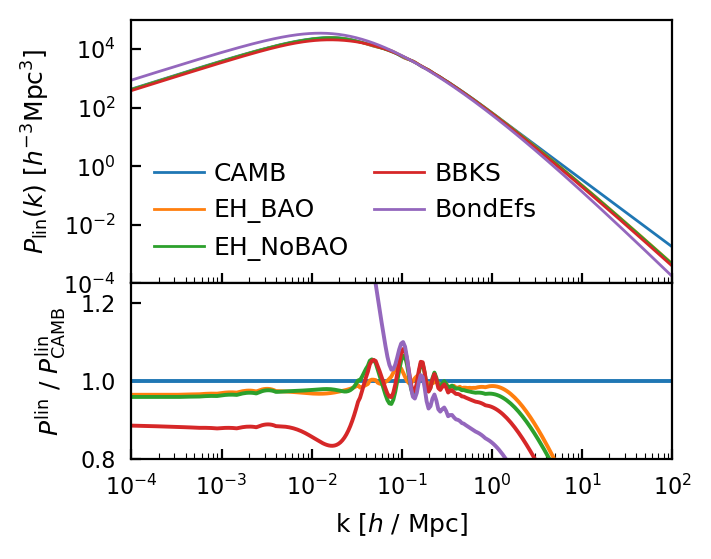

In [95]:
model_comparison_plot(
    module="hmf.density_field.transfer_models", 
    component = 'TransferComponent', 
    ignore=('FromFile','FromArray', 'EH'),
    attr_name = 'transfer_model',
    x = 'k',
    y = 'power',
    ylab = r"$P_{\rm lin}(k)$",
    y_unit = r"$h^{-3}{\rm Mpc}^3$",
    xlim = (1e-4, 1e2),
    yratio_lab = r"$P^{\rm lin}$",
    height_ratio = 1/1.2,
    ncol_legend=2,
    ylim=(1e-4, 1e5),
    comparison_limits=(0.8, 1.25)
)

First notice that the fiducial model is `CAMB` (this is only true if `camb` is installed, otherwise it is `EH_BAO`). Since `CAMB` has BAOs, all the models without BAOs show up in the ratio as having wiggles. Interestingly, `CAMB` has much higher power on small scales than the other models. `CAMB` is much slower to run than the other analytic models.

The normalization difference on large scales is due to the difference in the integral of the power spectrum, which is normalized to be the same value via $\sigma_8$. 

## Mass Definitions

Here we plot the change in mass and concentration when moving from one mass definition to another. 

In [97]:
from hmf.halos.mass_definitions import SOMean, SOCritical, SOVirial, FOF

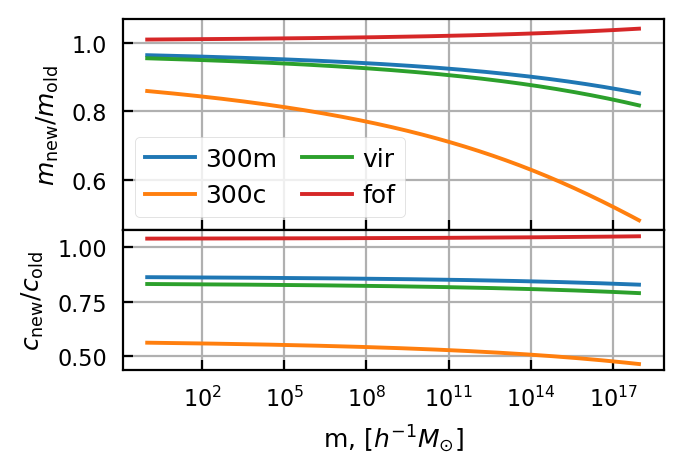

In [98]:
single_column(height_ratio=1/1.5)


fig, ax = plt.subplots(
    2, 1, sharex=True, 
    gridspec_kw={"hspace": 0, 'height_ratios': [3, 2]}, 
    subplot_kw={"xscale": 'log'}
)

for mdef in [SOMean(overdensity=300), SOCritical(overdensity=300), SOVirial(), FOF()]:
    m, r, c = base_model.mdef.change_definition(
        base_model.m, 
        mdef=mdef, 
        profile=base_model.halo_profile, 
        cosmo=base_model.cosmo
    )

    ax[0].plot(base_model.m, m / base_model.m, label=mdef.colossus_name)
    ax[1].plot(base_model.m, c / base_model.cmz_relation)
    
ax[0].grid(True)
ax[1].grid(True)

ax[0].legend(ncol=2, frameon=True)

ax[0].set_ylabel(r"$m_{\rm new} / m_{\rm old}$")
ax[1].set_ylabel(r"$c_{\rm new} / c_{\rm old}$")
ax[1].set_xlabel("m, [$h^{-1}M_{\odot}$]")

plt.savefig("plots/mass_conversion.pdf")


Notice that halos with a higher overdensity threshold move to lower masses and lower concentration. 

## Window Functions / Filters

The filter model, $W(x)$, is convolved with the power spectrum to produce the mass variance (which in turn is used to define the halo mass function). Optimally, the shape of the filter model is matched to the shape of primordial patches that become halos. However, typically a simplified model such as a top-hat is used.

(100000000.0, 1e+16)


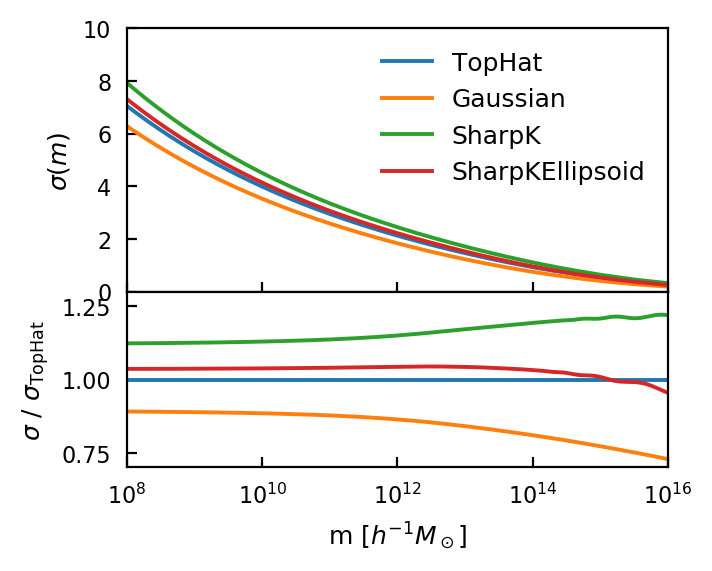

In [165]:
model_comparison_plot(
    module="hmf.density_field.filters", 
    component = 'Filter', 
    attr_name = 'filter_model',
    x = 'm',
    y = 'sigma',
    ylab = r"$\sigma(m)$",
    yratio_lab = r"$\sigma$",
    height_ratio = 1/1.2,
    ncol_legend=1,
    ylim=(0, 10),
    ylog=False,
    xlim=(1e8, 1e16),
    comparison_limits = (0.7, 1.3)
)

Note that while any of these can be used to generate $\sigma(m)$, the normalisation of the power spectrum, $\sigma(R=8)$, is always calculated using the `TopHat`. 

## Mass Function

There are many fitting functions for the HMF included in `hmf`. Some are fitted against FOF-haloes, while others are fitted to SO halos of various definitions. Here we'll only plot a few, so that the plot is not too confusing.

Randomly choosing 14 out of 19 models.


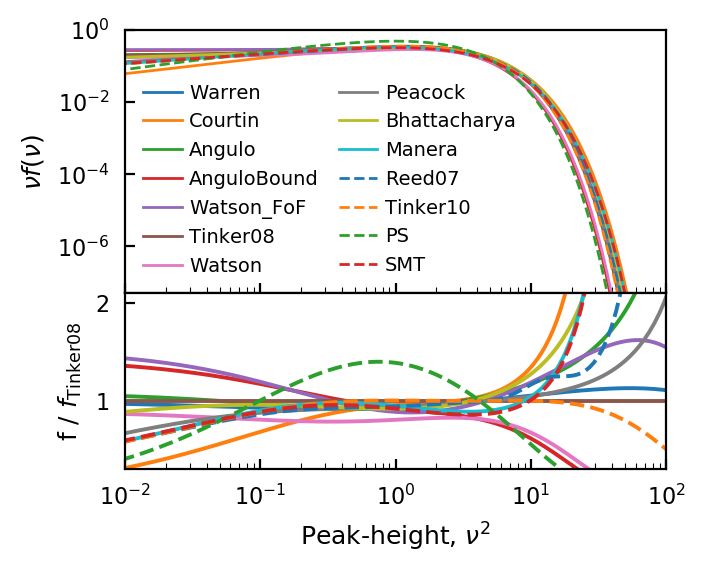

In [121]:
model_comparison_plot(
    module="hmf.mass_function.fitting_functions", 
    component = 'FittingFunction', 
    attr_name = 'hmf_model',
    x = 'nu',
    y = 'fsigma',
    ylab = r"$\nu f(\nu)$",
    height_ratio = 1/1.2,
    ncol_legend=2,
    ylim=(5e-8, 1),
    #ylog=False,
    xlim=(1e-2, 1e2),
    comparison_limits = (0.3, 2.1),
    must_include = ("PS", "SMT"),
    ignore=("ST", "Jenkins"),  # Jenkins gets in the way of the legend
    legend_size=7,
    max_models = 14,
    yratio_lab = "f"
)

## Bias

The halo bias describes the clustering strength of halos of a given mass compared to the background matter. 

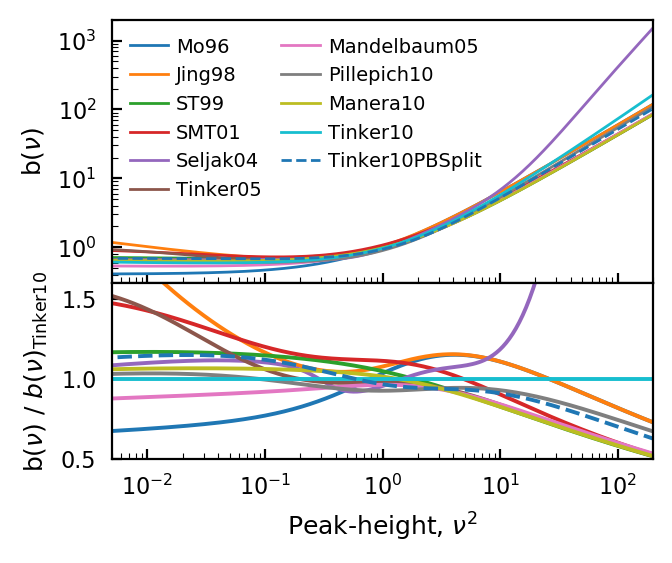

In [132]:
model_comparison_plot(
    module="halomod.bias", 
    component = 'Bias', 
    attr_name = 'bias_model',
    x = 'nu',
    y = 'halo_bias',
    ylab = r"b($\nu$)",
    height_ratio = 1/1.2,
    ncol_legend=2,
    comparison_limits = (0.5, 1.6),
    must_include = ('Tinker05', 'Mandelbaum05', "ST99", "SMT01", 'Mo96', 'Jing98'),
    ignore=("UnityBias", "Seljak04Cosmo"),
    legend_size = 7,
    max_models=11,
    xlim=(5e-3, 200),
    ylim=(3e-1, 2e3)
)

Note that even more bias models are available via `colossus`!

## Concentration

The concentration-mass relation affects the shape of the halo profile at different masses. `halomod` includes physically-motivated forms (eg. Bullock and Ludlow) and power-law forms.

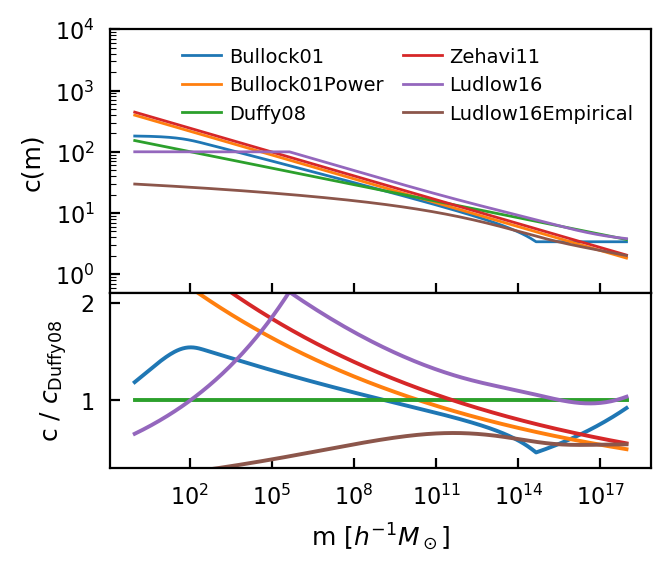

In [137]:
model_comparison_plot(
    module="halomod.concentration", 
    component = 'CMRelation', 
    attr_name = 'halo_concentration_model',
    x = 'm',
    y = 'cmz_relation',
    ylab = r"c(m)",
    yratio_lab = "c",
    height_ratio = 1/1.2,
    ncol_legend=2,
    comparison_limits = (0.3, 2.1),
    ignore=("Ludlow2016", "Ludlow2016Empirical"),
    legend_size = 7,
    ylim=(5e-1, 1e4)
)

Notice that both of the physical forms have discontinuities, which arise when the predicted redshift of formation for a given halo mass is less than zero. This typically does not present a problem for the halo model, for which intermediate masses are the most important.

## Halo Exclusion

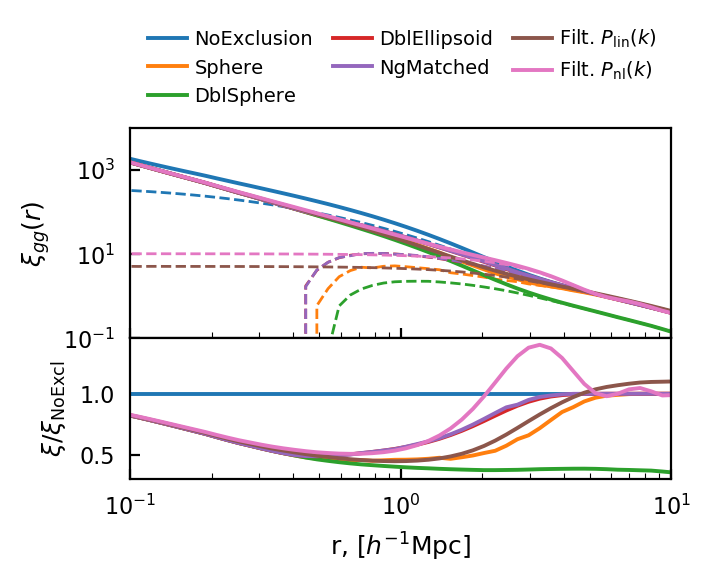

In [89]:
model = base_model.clone()

single_column(height_ratio=1/1.5)

fig, ax = plt.subplots(
    2, 1, sharex=True, 
    gridspec_kw={"hspace": 0, 'height_ratios': [3, 2]}, 
    subplot_kw={"xscale": 'log'}
)

for i, excl in enumerate(['NoExclusion', 'Sphere', 'DblSphere_', 'DblEllipsoid_', 'NgMatched_']):
    model.exclusion_model = excl
    
    ax[0].plot(model.r, model.corr_auto_tracer, label=excl.replace("_", ""), color=f'C{i}')
    ax[0].plot(model.r, model.corr_2h_auto_tracer, ls='--', color=f'C{i}', lw=1)
    ax[1].plot(model.r, model.corr_auto_tracer / base_model.corr_auto_tracer)
    
model.exclusion_model = 'NoExclusion'

model.hc_spectrum = 'filtered-lin'
ax[0].plot(model.r, model.corr_auto_tracer, label=r"Filt. $P_{\rm lin}(k)$", color=f'C{i+1}')
ax[0].plot(model.r, model.corr_2h_auto_tracer, ls='--', color=f'C{i+1}', lw=1)
ax[1].plot(model.r, model.corr_auto_tracer / base_model.corr_auto_tracer, )

model.hc_spectrum = 'filtered-nl'
ax[0].plot(model.r, model.corr_auto_tracer, label=r"Filt. $P_{\rm nl}(k)$", color=f'C{i+2}')
ax[0].plot(model.r, model.corr_2h_auto_tracer, ls='--', color=f'C{i+2}', lw=1)
ax[1].plot(model.r, model.corr_auto_tracer / base_model.corr_auto_tracer, )

ax[0].legend(ncol=3, frameon=False, fontsize=7, bbox_to_anchor=(0., 1.02, 1., .102))
ax[0].set_yscale('log')

ax[0].set_xlim(1e-1, 1e1)
ax[0].set_ylim(1e-1, 1e4)
ax[1].set_ylabel(r"$\xi / \xi_{\rm No Excl}$")
ax[0].set_ylabel(r"$\xi_{gg}(r)$")
ax[1].set_xlabel("r, [$h^{-1}$Mpc]")

plt.savefig("plots/halo_exclusion.pdf")

## HOD

For the HOD, we'll only be showing models of point-source-like tracers (i.e. galaxies). A whole set of HOD models for continuous tracers (eg. HI gas) are also available. Also note that these models look very similar to each other. This is by design. Most of the models are essentially nested (i.e. you can get back `Zehavi05` from setting some of the `Contreras13` parameters to zero or one). By default, `halomod` sets the parameters so that the model returns the same or a similar occupation function. However, the HOD is not fundamental in nature -- it depends on the actual galaxy sample being observed (and its depth/wavelength etc), so these models can vary widely for different parameters.

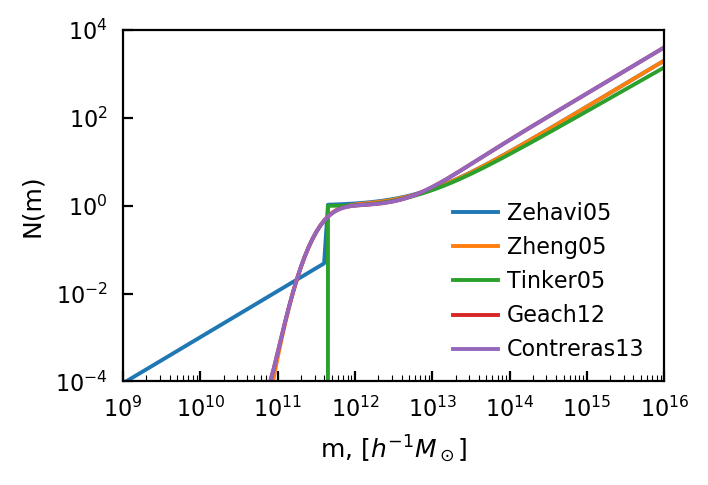

In [139]:
single_column(height_ratio=1/1.5)

model = base_model.clone()
for hod in ['Zehavi05', 'Zheng05', 'Tinker05',  'Geach12', 'Contreras13']:
    model.hod_model = hod
    plt.plot(model.m, model.total_occupation, label=hod)
    
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4, 1e4)
plt.xlim(1e9, 1e16)
plt.legend(fontsize=8)

plt.xlabel("m, [$h^{-1}M_\odot$]")
plt.ylabel("N(m)")
plt.savefig("plots/hod_models.pdf")

The key things to recognize are a low-mass cutoff, essentially corresponding to the depth of the survey, and a high-mass powerlaw with slope close to one (i.e. doubling halo mass doubles the occupancy). The differentiation between central and satellite halos causes the bump seen above at $m\sim10^{12}$. 

## Profiles

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


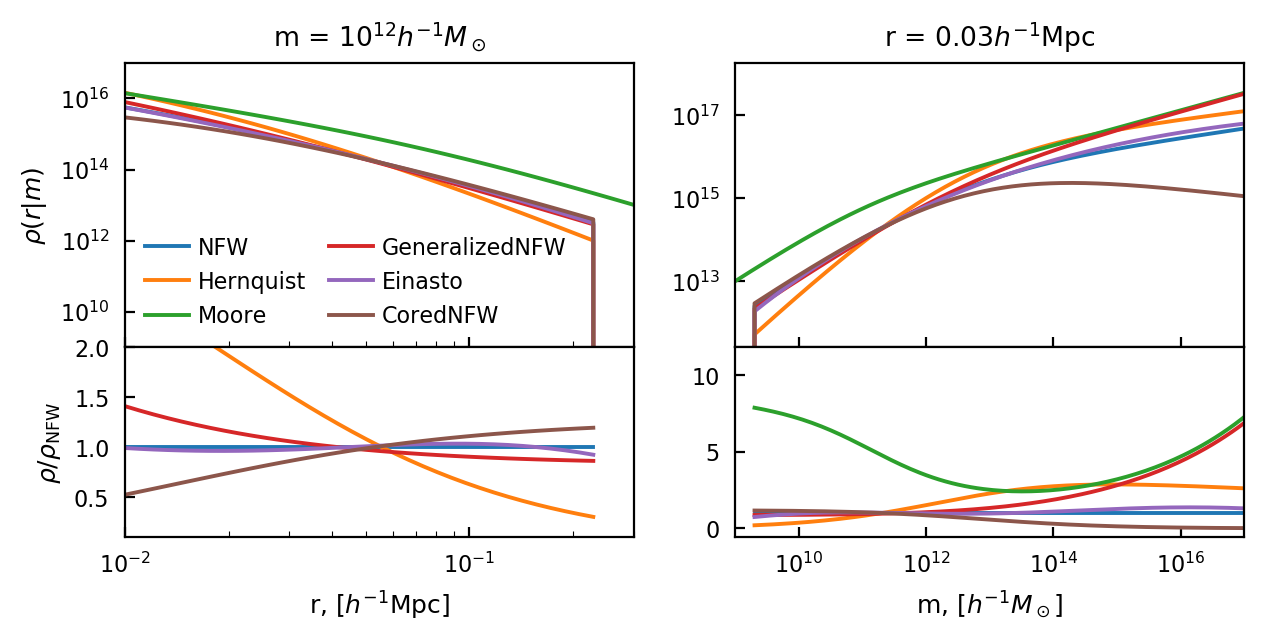

In [43]:
two_column(height_ratio=1/2.3)

fig, ax = plt.subplots(
    2, 2, sharex='col', 
    gridspec_kw={"hspace": 0, 'height_ratios': [3, 2]}, 
    subplot_kw={"xscale": 'log'}
)

profiles = get_models("halomod.profiles", 'Profile', ignore=("ProfileInf", "Constant", "NFWInf", "HernquistInf", "MooreInf", "GeneralizedNFWInf"))

model = base_model.clone()
for profile in profiles:
    model.halo_profile_model = profile
    model.halo_profile_params = {'alpha': 1.5} if profile.__name__ == "GeneralizedNFW" else {}
    ax[0, 0].plot(model.r, model.halo_profile.rho(model.r, np.array([1e12])), label=profile.__name__)
    ax[1, 0].plot(model.r, model.halo_profile.rho(model.r, np.array([1e12])) /base_model.halo_profile.rho(model.r, np.array([1e12])))
    
    ax[0, 1].plot(model.m, model.halo_profile.rho(0.03, model.m), label=profile.__name__)
    ax[1, 1].plot(model.m, model.halo_profile.rho(0.03, model.m) / base_model.halo_profile.rho(0.03, model.m))
    
ax[0, 0].set_yscale('log')
ax[0, 1].set_yscale('log')

ax[0, 0].set_ylim(1e9, 1e17)
ax[0, 0].set_xlim(1e-2, 0.3)
ax[0, 0].legend(ncol=2, fontsize=8)
ax[1, 0].set_ylim(0.1, 2)

ax[0, 1].set_yscale('log')
#ax[0].set_ylim(1e9, 1e17)
ax[0, 1].set_xlim(1e9, 1e17)

ax[1, 0].set_xlabel(r"r, [$h^{-1}{\rm Mpc}$]")
ax[0, 0].set_ylabel(r"$\rho(r|m)$");

ax[0,0].set_title("m = $10^{12} h^{-1}M_\odot$")
ax[0,1].set_title("r = $0.03 h^{-1}$Mpc")

ax[1, 1].set_xlabel(r"m, [$h^{-1}M_\odot$]")
ax[1, 0].set_ylabel(r"$\rho/\rho_{\rm NFW}$")

plt.savefig("plots/profile_models.pdf")

We show here the profile for six models, plotted against mass and radius. We omit the "Inf" versions of each profile, since they are the same but extend to infinity (and are less useful for the halo model itself since some of them contain infinite mass). 